In [1]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [2]:
import pandas as pd

train = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_hld_train.csv")
test = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_hld_test.csv")
cus = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/cus_info.csv")
iem = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/iem_info_20210902.csv")
hist = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_bnc_hist.csv")
submission = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/sample_submission.csv")

In [3]:
train.head(3)

,act_id,iem_cd,byn_dt,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5


In [4]:
test.head(3)

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0


In [5]:
train["hist_d"] = train["hold_d"]*0.877
train.hist_d = np.trunc(train["hist_d"])

In [6]:
train

,act_id,iem_cd,byn_dt,hold_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,9.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,70.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,4.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,19.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,284.0
...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,20180831,1,0.0
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A271980,20201027,1,0.0
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,20181121,1,0.0
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,20200214,1,0.0


In [7]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [8]:
train_data.shape

(681472, 18)

In [9]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

In [10]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

In [11]:
train_data.head(3)

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,9.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,70.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,4.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0


In [12]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,9.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,70.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,4.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0
3,19.0,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,284.0,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,0.0,1,4,4,2,2,3,4,3,8,1752,10,3,99,199.0,3532250.0,500.0,17750.0
681468,0.0,1,4,4,2,2,3,4,3,8,2344,8,2,99,488.0,22960400.0,500.0,47050.0
681469,0.0,1,4,4,2,2,3,4,3,8,521,2,2,99,2210.0,9204650.0,500.0,4165.0
681470,0.0,1,4,4,2,2,3,4,3,8,2460,2,3,99,285.0,2721750.0,500.0,9550.0


In [13]:
test_data.head(3)

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,153,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,139,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0


In [14]:
train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

## 딥러닝

In [15]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.0


In [16]:
train_data.shape

(681472, 18)

In [17]:
train_label.shape

(681472,)

In [18]:
train_label = train_label.values.reshape((-1,1))

In [19]:
train_label.shape

(681472, 1)

In [20]:
# from sklearn.model_selection import train_test_split

# train_x, val_x, train_y, val_y = train_test_split(train_data, train_label, test_size=0.2, random_state=34)

In [21]:
# print(train_x.shape)
# print(train_y.shape)
# print(val_x.shape)
# print(val_y.shape)

In [22]:
def build_model():
    model = keras.Sequential([
        layers.Dense(16,input_shape=[18], activation='relu'),
        layers.Dense(8,input_shape=[16], activation='relu'),
        layers.Dense(4,input_shape=[8], activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

In [23]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                304       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [24]:
EPOCHS = 500
history = model.fit(train_data, train_label, epochs=EPOCHS, validation_split=0.2, verbose=1)
history

Epoch 1/500
17037/17037 [==============================] - 46s 3ms/step - loss: 457590.1371 - mae: 32.1539 - val_loss: 478.8219 - val_mae: 13.5001
Epoch 2/500
17037/17037 [==============================] - 34s 2ms/step - loss: 3340.2007 - mae: 23.5209 - val_loss: 530.7282 - val_mae: 17.2296
Epoch 3/500
17037/17037 [==============================] - 43s 3ms/step - loss: 5707.3385 - mae: 26.1540 - val_loss: 528.6727 - val_mae: 17.6533
Epoch 4/500
17037/17037 [==============================] - 42s 2ms/step - loss: 242096.5235 - mae: 30.4474 - val_loss: 3460.3550 - val_mae: 17.0258
Epoch 5/500
17037/17037 [==============================] - 43s 3ms/step - loss: 28205.4300 - mae: 26.3285 - val_loss: 455.5452 - val_mae: 15.5184
Epoch 6/500
17037/17037 [==============================] - 44s 3ms/step - loss: 68115.8822 - mae: 25.1449 - val_loss: 326.3655 - val_mae: 13.3114
Epoch 7/500
17037/17037 [==============================] - 41s 2ms/step - loss: 55359.0677 - mae: 24.1311 - val_loss: 404.4

17037/17037 [==============================] - 41s 2ms/step - loss: 568.6163 - mae: 6.2504 - val_loss: 96.9667 - val_mae: 4.9294
Epoch 58/500
17037/17037 [==============================] - 41s 2ms/step - loss: 720.5664 - mae: 6.3326 - val_loss: 78.4546 - val_mae: 4.1248
Epoch 59/500
17037/17037 [==============================] - 41s 2ms/step - loss: 651.2444 - mae: 6.4259 - val_loss: 42.0433 - val_mae: 3.4238
Epoch 60/500
17037/17037 [==============================] - 41s 2ms/step - loss: 8741.6851 - mae: 6.8266 - val_loss: 27.1622 - val_mae: 3.4067
Epoch 61/500
17037/17037 [==============================] - 41s 2ms/step - loss: 2449.9486 - mae: 6.7248 - val_loss: 88.9846 - val_mae: 5.2851
Epoch 62/500
17037/17037 [==============================] - 41s 2ms/step - loss: 682.0690 - mae: 6.5088 - val_loss: 89.4748 - val_mae: 4.9150
Epoch 63/500
17037/17037 [==============================] - 42s 2ms/step - loss: 1429.0447 - mae: 7.0062 - val_loss: 145.1348 - val_mae: 5.7611
Epoch 64/500
17

17037/17037 [==============================] - 41s 2ms/step - loss: 804.2898 - mae: 6.3981 - val_loss: 50.5380 - val_mae: 3.6194
Epoch 115/500
17037/17037 [==============================] - 41s 2ms/step - loss: 705.9674 - mae: 6.1732 - val_loss: 105.6679 - val_mae: 5.3453
Epoch 116/500
17037/17037 [==============================] - 41s 2ms/step - loss: 3166.2396 - mae: 6.6265 - val_loss: 27.7425 - val_mae: 2.8678
Epoch 117/500
17037/17037 [==============================] - 41s 2ms/step - loss: 740.5874 - mae: 6.0261 - val_loss: 60.7702 - val_mae: 3.9047
Epoch 118/500
17037/17037 [==============================] - 41s 2ms/step - loss: 518.9813 - mae: 5.5721 - val_loss: 71.1187 - val_mae: 3.9274
Epoch 119/500
17037/17037 [==============================] - 41s 2ms/step - loss: 751.4308 - mae: 5.9710 - val_loss: 25.7706 - val_mae: 3.2371
Epoch 120/500
17037/17037 [==============================] - 41s 2ms/step - loss: 565.4971 - mae: 6.0096 - val_loss: 362.8477 - val_mae: 5.2835
Epoch 121/

17037/17037 [==============================] - 39s 2ms/step - loss: 475.5840 - mae: 5.6698 - val_loss: 43.9926 - val_mae: 3.5977
Epoch 172/500
17037/17037 [==============================] - 41s 2ms/step - loss: 791.3073 - mae: 5.7069 - val_loss: 67.1032 - val_mae: 3.8769
Epoch 173/500
17037/17037 [==============================] - 41s 2ms/step - loss: 422.5313 - mae: 5.0496 - val_loss: 124.8505 - val_mae: 5.9049
Epoch 174/500
17037/17037 [==============================] - 41s 2ms/step - loss: 455.9085 - mae: 5.2167 - val_loss: 98.2868 - val_mae: 5.0641
Epoch 175/500
17037/17037 [==============================] - 41s 2ms/step - loss: 489.0799 - mae: 5.1615 - val_loss: 45.1771 - val_mae: 3.0633
Epoch 176/500
17037/17037 [==============================] - 41s 2ms/step - loss: 388.4162 - mae: 5.2486 - val_loss: 51.7551 - val_mae: 2.7939
Epoch 177/500
17037/17037 [==============================] - 41s 2ms/step - loss: 1479.3376 - mae: 5.2845 - val_loss: 11.6978 - val_mae: 2.2176
Epoch 178/5

17037/17037 [==============================] - 12s 684us/step - loss: 469.0518 - mae: 5.2882 - val_loss: 17.1512 - val_mae: 2.0726
Epoch 229/500
17037/17037 [==============================] - 12s 686us/step - loss: 708.7461 - mae: 5.3952 - val_loss: 45.5347 - val_mae: 3.5393
Epoch 230/500
17037/17037 [==============================] - 11s 664us/step - loss: 363.5535 - mae: 5.1552 - val_loss: 21.1479 - val_mae: 2.0910
Epoch 231/500
17037/17037 [==============================] - 12s 684us/step - loss: 404.5944 - mae: 5.1465 - val_loss: 47.3092 - val_mae: 3.5923
Epoch 232/500
17037/17037 [==============================] - 11s 653us/step - loss: 1468.4804 - mae: 5.1589 - val_loss: 21.7228 - val_mae: 2.1698
Epoch 233/500
17037/17037 [==============================] - 11s 619us/step - loss: 342.3737 - mae: 5.1753 - val_loss: 70.8097 - val_mae: 4.3736
Epoch 234/500
17037/17037 [==============================] - 11s 620us/step - loss: 463.5272 - mae: 5.6899 - val_loss: 75.7760 - val_mae: 4.512

17037/17037 [==============================] - 11s 624us/step - loss: 1832.1318 - mae: 5.5150 - val_loss: 58.8011 - val_mae: 3.7659
Epoch 285/500
17037/17037 [==============================] - 11s 627us/step - loss: 406.0742 - mae: 5.3395 - val_loss: 9.8246 - val_mae: 2.0186
Epoch 286/500
17037/17037 [==============================] - 11s 624us/step - loss: 381.0804 - mae: 5.2372 - val_loss: 55.9470 - val_mae: 3.4158
Epoch 287/500
17037/17037 [==============================] - 10s 614us/step - loss: 1194.6574 - mae: 5.1624 - val_loss: 36.1301 - val_mae: 2.7982
Epoch 288/500
17037/17037 [==============================] - 10s 608us/step - loss: 487.9906 - mae: 5.2412 - val_loss: 71.2955 - val_mae: 4.2605
Epoch 289/500
17037/17037 [==============================] - 11s 648us/step - loss: 426.1493 - mae: 5.0481 - val_loss: 47.9364 - val_mae: 3.2112
Epoch 290/500
17037/17037 [==============================] - 12s 679us/step - loss: 497.6029 - mae: 5.2773 - val_loss: 32.4510 - val_mae: 3.350

17037/17037 [==============================] - 8s 477us/step - loss: 275.3338 - mae: 4.4708 - val_loss: 6.3507 - val_mae: 1.9430
Epoch 341/500
17037/17037 [==============================] - 8s 474us/step - loss: 424.2240 - mae: 4.6589 - val_loss: 25.2117 - val_mae: 2.7367
Epoch 342/500
17037/17037 [==============================] - 8s 476us/step - loss: 750.2309 - mae: 4.5043 - val_loss: 3.0652 - val_mae: 1.3687
Epoch 343/500
17037/17037 [==============================] - 8s 483us/step - loss: 294.5219 - mae: 4.4143 - val_loss: 58.1402 - val_mae: 3.6324
Epoch 344/500
17037/17037 [==============================] - 8s 483us/step - loss: 342.3488 - mae: 4.5132 - val_loss: 19.0437 - val_mae: 2.2429
Epoch 345/500
17037/17037 [==============================] - 8s 480us/step - loss: 372.5833 - mae: 4.2804 - val_loss: 36.6298 - val_mae: 2.7224
Epoch 346/500
17037/17037 [==============================] - 8s 479us/step - loss: 365.0480 - mae: 4.5287 - val_loss: 54.2772 - val_mae: 4.0566
Epoch 34

Epoch 397/500
17037/17037 [==============================] - 8s 480us/step - loss: 360.4690 - mae: 4.4347 - val_loss: 16.8591 - val_mae: 2.0335
Epoch 398/500
17037/17037 [==============================] - 8s 477us/step - loss: 344.7518 - mae: 4.4321 - val_loss: 18.7900 - val_mae: 3.0077
Epoch 399/500
17037/17037 [==============================] - 8s 475us/step - loss: 221.1413 - mae: 4.4344 - val_loss: 156.2854 - val_mae: 6.2834
Epoch 400/500
17037/17037 [==============================] - 9s 535us/step - loss: 567.7038 - mae: 4.4651 - val_loss: 18.6127 - val_mae: 1.9704
Epoch 401/500
17037/17037 [==============================] - 10s 608us/step - loss: 273.8927 - mae: 4.4261 - val_loss: 50.3903 - val_mae: 2.8569
Epoch 402/500
17037/17037 [==============================] - 8s 481us/step - loss: 363.3346 - mae: 4.4245 - val_loss: 15.2154 - val_mae: 2.3223
Epoch 403/500
17037/17037 [==============================] - 8s 480us/step - loss: 310.8446 - mae: 4.3723 - val_loss: 31.4596 - val_ma

Epoch 454/500
17037/17037 [==============================] - 8s 496us/step - loss: 253.5825 - mae: 3.8073 - val_loss: 36.5191 - val_mae: 2.7373
Epoch 455/500
17037/17037 [==============================] - 8s 495us/step - loss: 426.4590 - mae: 3.8816 - val_loss: 15.3517 - val_mae: 2.0294
Epoch 456/500
17037/17037 [==============================] - 8s 492us/step - loss: 283.4444 - mae: 3.8068 - val_loss: 1058.6489 - val_mae: 14.1154
Epoch 457/500
17037/17037 [==============================] - 9s 507us/step - loss: 296.7223 - mae: 3.8985 - val_loss: 29.8406 - val_mae: 2.3982
Epoch 458/500
17037/17037 [==============================] - 8s 496us/step - loss: 289.1325 - mae: 3.7529 - val_loss: 99.6400 - val_mae: 4.3946
Epoch 459/500
17037/17037 [==============================] - 9s 528us/step - loss: 239.7069 - mae: 3.7963 - val_loss: 22.5932 - val_mae: 2.1203
Epoch 460/500
17037/17037 [==============================] - 9s 502us/step - loss: 335.2156 - mae: 3.8943 - val_loss: 26.3319 - val_m

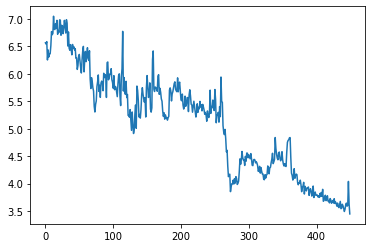

In [25]:
plt.plot(history.history['mae'][50:])

In [26]:
test_data.shape

(70596, 18)

In [27]:
submission["hold_d"] = model.predict(test_data)

In [28]:
submission["hold_d"] = np.round(submission["hold_d"]).astype('int')

In [29]:
submission['hold_d'].unique()

array([ 179,  385,  162, ...,  400, 1390,  981])

In [46]:
submission.to_csv("20211010_dnn2.csv", index = False)

## 